<a href="https://colab.research.google.com/github/jimtoberfest/Cointegration_Testing/blob/main/Large_Cointegration_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install yfinance -q

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 8.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


#Imports

In [111]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import scipy

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

# Functions

In [112]:
# Doesnt work well...need to fix some yFinance integrations



def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,2),dtype=object)
    m = 0
    #loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                m = m +1
    return result, pvalue_matrix,  pairs

In [113]:
# Basic cointegration

def cointegration(a, b):
  if ts.coint(a, b)[1] < 0.05:
    print('The series are cointegrated')
    print('p-value = ', ts.coint(a, b)[1])
  else:
    print('The series are NOT cointegrated')
    print('p-value = ', ts.coint(a, b)[1])

In [114]:
def stationarity(a, cutoff = 0.05):
  a = np.ravel(a)
  if adfuller(a)[1] < cutoff:
    print('The series is stationary')
    print('p-value = ', adfuller(a)[1])
  else:
    print('The series is NOT stationary')
    print('p-value = ', adfuller(a)[1])

# Initial Testing

## Download Data

In [115]:
# HST vs DRH, 



today = datetime.today()
sp_list = ['BDX','ALL']
offset = max(1, (today.weekday() + 6) % 7 - 3)
timed = timedelta(offset)
today_business = today - timed
print("d1 =", today_business)
today = today_business.strftime("%Y-%m-%d")
start = '2019-01-01' 
end = today
# end = '2018-01-01'
end = '2021-12-31'
print('S&P500 Stock download')
spy = yf.download(sp_list, start,end)

d1 = 2022-01-27 03:11:26.501168
S&P500 Stock download
[*********************100%***********************]  2 of 2 completed


## **Sofien Based Code**

In [116]:
EWC = spy['Adj Close'][sp_list[0]].values
EWA = spy['Adj Close'][sp_list[1]].values

S1 = EWC
S2 = EWA

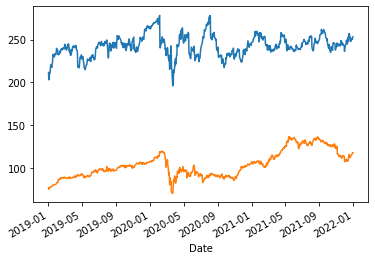

In [117]:
spy['Adj Close'][sp_list[0]].plot()
spy['Adj Close'][sp_list[1]].plot()

### Pearson Correlation

In [118]:
np.corrcoef(S1, S2)

array([[1.        , 0.39645675],
       [0.39645675, 1.        ]])

In [119]:
scipy.stats.pearsonr(S1,S2)

(0.3964567545144752, 7.316703083884684e-30)

### Stationarity

In [120]:
stationarity(S1)

The series is stationary
p-value =  0.0003050826761428417


In [121]:
stationarity(S2)

The series is NOT stationary
p-value =  0.3285680644661596


### Cointegration

In [122]:
cointegration(S1,S2)

The series are cointegrated
p-value =  0.0012150158497503782


##Explore DF

In [123]:
df = pd.DataFrame(columns=['S1', 'S2'])

In [124]:
# Trying to make time series stationary in some way... trying log diff of prices and simple ratio of prices
# Then calculating 2 stdev bands, to see if asset prices revert to mean after exceeding 2 or 2.5 stdev up or down


df['S1']= S1.tolist()
df['S2']= S2.tolist()
df['s1_log'] = np.log(df['S1'] / df['S1'].shift(1))
df['s2_log'] = np.log(df['S2'] / df['S2'].shift(1))
df['log_ratio'] = df['s2_log'] / df['s1_log'] 
df['ratio'] = df['S2'] / df['S1']

window = 42
zs = 2.0

df['log_30_mean'] = df['log_ratio'].rolling(window=window).mean()
df['log_30_std'] = df['log_ratio'].rolling(window=window).std()

df['30_mean'] = df['ratio'].rolling(window=window).mean()
df['30_std'] = df['ratio'].rolling(window=window).std()


df['up_2'] = df['30_mean'] + (df['30_std'] * zs)
df['down_2'] = df['30_mean'] - (df['30_std'] * zs)
df['up_1'] = df['30_mean'] + (df['30_std'] * zs/2)
df['down_1'] = df['30_mean'] - (df['30_std'] * zs/2)

# df['log_up_2'] = df['log_30_mean'] + (df['log_30_std'] * 6)
# df['log_down_2'] = df['log_30_mean'] - (df['log_30_std'] * 6)



df.fillna(0, inplace=True)

In [125]:
df.tail(3)

,S1,S2,s1_log,s2_log,log_ratio,ratio,log_30_mean,log_30_std,30_mean,30_std,up_2,down_2,up_1,down_1
753,250.210007,117.089996,-0.004426,0.008663,-1.957141,0.467967,0.627372,5.588403,0.463685,0.022126,0.507937,0.419433,0.485811,0.441559
754,252.789993,117.949997,0.010258,0.007318,0.713355,0.466593,0.653904,5.586046,0.462247,0.019744,0.501735,0.422758,0.481991,0.442502
755,253.259995,117.680000,0.001858,-0.002292,-1.233736,0.464661,0.749480,5.516512,0.461063,0.017953,0.496970,0.425157,0.479016,0.443110


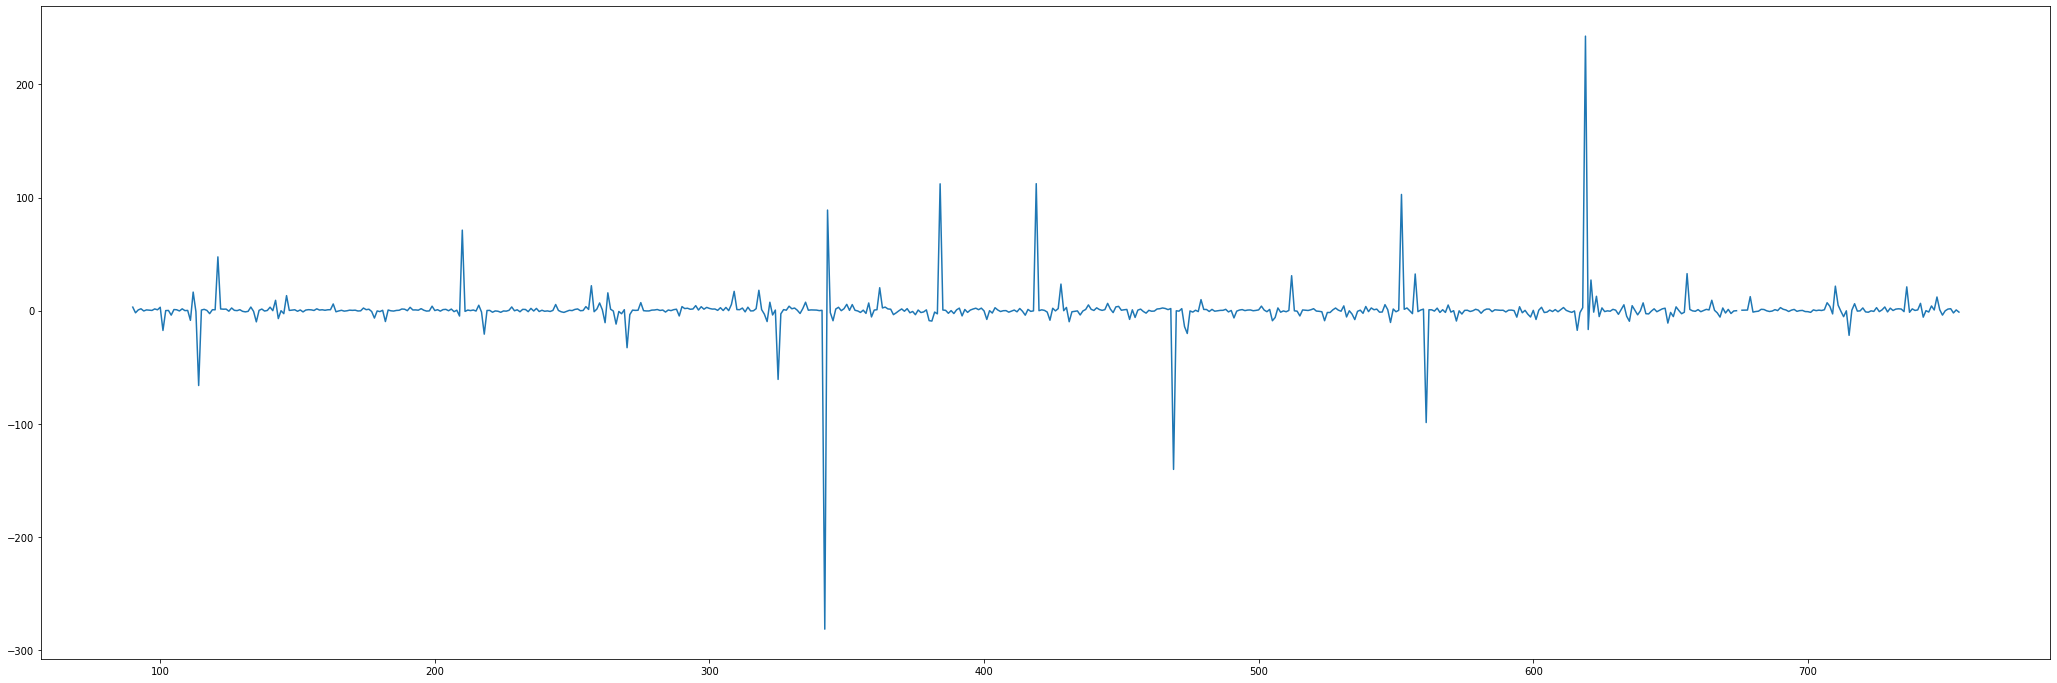

In [126]:
plt.figure(figsize=(36, 12))


df['log_ratio'][90:].plot()

# df['ratio'][60:].plot()
# df['30_mean'][60:].plot()
# df['log_up_2'][90:].plot()
# df['log_down_2'][90:].plot()


### Ratio Chart

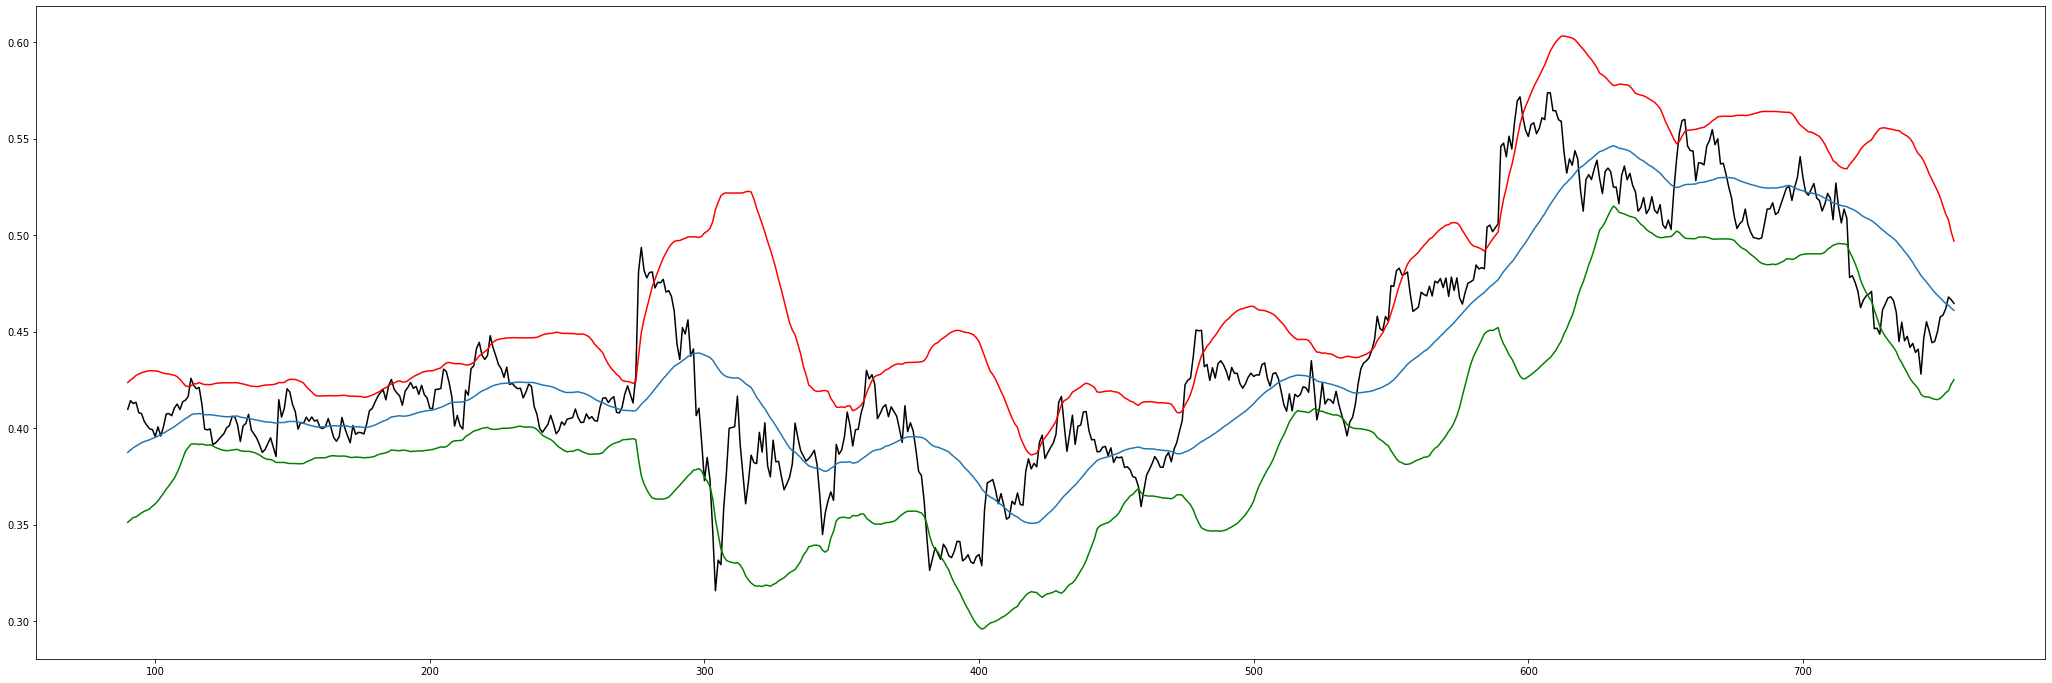

In [127]:
plt.figure(figsize=(36, 12))


df['ratio'][90:].plot(color='k')


df['30_mean'][90:].plot()
df['up_2'][90:].plot(color='r')
df['down_2'][90:].plot(color='g')


# df['up_1'][60:].plot()
# df['down_1'][60:].plot()

# Pairs Search

## Pairs Download

In [134]:
start = '2019-01-01'
end = '2022-01-21'

# end = today

In [135]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df_table = first_table
symbols = df_table['Symbol'].values.tolist()



In [136]:

symbols = symbols[:100]  #reduce number for testing

stock_list = []

stock_list = symbols


data = yf.download(stock_list, start,end)

[*********************100%***********************]  100 of 100 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [137]:
df = data['Adj Close']
df.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [138]:
tickers = df.columns.to_list()
df.corr(method='pearson')

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMY,BR,BRK.B,BRO,BSX,BWA,BXP,CAH,CARR,CAT,CBOE,CBRE,CCL,CDAY,CDNS,CDW,CE,CERN,CHRW,CNC,CNP,COF,CPB,CTLT,CZR,GOOG,GOOGL,KMX,LNT,MMM,MO,T,TECH
A,1.000000,-0.334423,0.828530,0.937617,0.924661,0.939000,0.682063,0.935943,0.955657,0.948098,0.963250,0.939368,0.848258,0.913722,0.798134,0.307543,0.861006,0.526310,0.439036,0.893332,0.953080,0.755996,0.958971,0.963520,0.121226,0.792041,0.809348,0.957381,0.853670,0.905994,0.944719,0.578409,0.949024,0.785054,0.875617,0.794418,0.884951,0.888175,0.902905,0.915746,...,0.210213,0.962210,0.637682,0.778282,0.403995,0.983157,0.816943,0.735959,0.930260,NaN,0.908979,0.407002,0.709758,-0.021176,0.640978,0.944710,0.905736,0.416580,0.912498,-0.494468,0.916836,0.956173,0.927340,0.883556,0.669007,0.723625,0.666474,0.130271,0.871961,0.294575,0.953276,0.894823,0.980836,0.980407,0.887794,0.775396,0.636472,0.651359,-0.259601,0.981745
AAL,-0.334423,1.000000,0.092547,-0.547933,-0.404847,-0.408930,-0.002646,-0.468732,-0.330052,-0.526113,-0.257039,-0.173102,-0.007795,-0.475205,-0.283508,0.060863,-0.094857,0.513397,0.540119,-0.198265,-0.322480,-0.671241,-0.241816,-0.237564,0.785589,-0.006259,-0.095790,-0.278327,-0.138400,-0.544429,-0.259762,-0.592403,-0.187898,-0.540335,-0.616122,-0.033008,-0.593072,-0.099359,-0.222703,-0.144580,...,-0.062764,-0.539486,0.392532,0.145759,0.618639,-0.352331,-0.487506,-0.530012,-0.306453,NaN,-0.442689,0.360968,0.187331,0.812993,-0.261929,-0.563160,-0.171368,0.319355,-0.047294,0.959514,-0.501843,-0.460517,-0.196008,-0.030778,-0.328566,-0.202591,-0.359479,0.781179,0.075663,-0.636825,-0.511434,-0.005359,-0.302824,-0.303607,-0.241599,-0.278268,0.309753,0.336450,0.323955,-0.323124
AAP,0.828530,0.092547,1.000000,0.710398,0.777849,0.778229,0.705417,0.739756,0.859541,0.708836,0.845418,0.884147,0.889406,0.655484,0.703879,0.324651,0.749777,0.778820,0.714947,0.774746,0.845704,0.460685,0.864322,0.814362,0.413649,0.722429,0.704659,0.831620,0.809430,0.711206,0.832537,0.287012,0.895730,0.560902,0.607660,0.888800,0.603084,0.908170,0.829098,0.922408,...,0.044538,0.713948,0.882069,0.835931,0.692712,0.820869,0.576654,0.431266,0.826355,NaN,0.764141,0.588834,0.838041,0.345231,0.448908,0.696704,0.800460,0.602064,0.900609,-0.081838,0.661129,0.774648,0.841000,0.891184,0.545358,0.746169,0.572887,0.553573,0.886019,-0.016945,0.704237,0.845858,0.856766,0.858035,0.796480,0.661389,0.760047,0.808391,-0.183264,0.829742
AAPL,0.937617,-0.547933,0.710398,1.000000,0.940117,0.938889,0.582540,0.969342,0.940598,0.958649,0.916247,0.885515,0.761995,0.932420,0.795786,0.301992,0.812819,0.347222,0.259414,0.843931,0.936584,0.865936,0.888740,0.891353,-0.063550,0.676921,0.742246,0.914796,0.812265,0.967507,0.925639,0.708566,0.896554,0.808576,0.946794,0.714558,0.968263,0.812622,0.848181,0.854845,...,0.115409,0.966694,0.450116,0.676729,0.200259,0.949053,0.880082,0.803787,0.914499,NaN,0.940990,0.272201,0.620570,-0.221232,0.654157,0.961842,0.856651,0.269796,0.809744,-0.679894,0.935203,0.971604,0.871005,0.804465,0.753685,0.753199,0.696531,-0.078005,0.724349,0.489844,0.966422,0.784915,0.923395,0.923986,0.871623,0.778116,0.458209,0.485306,-0.258145,0.913890
ABBV,0.924661,-0.404847,0.777849,0.940117,1.000000,0.938873,0.612459,0.917503,0.922650,0.889746,0.914260,0.915418,0.813685,0.897495,0.769196,0.303798,0.819514,0.461346,0.343859,0.827246,0.930827,0.785239,0.893003,0.891657,0.061494,0.737447,0.780792,0.932990,0.812409,0.902277,0.923231,0.692852,0.918860,0.759509,0.867825,0.771038,0.892518,0.877219,0.843310,0.893256,...,0.223257,0.905319,0.591649,0.714968,0.339353,0.946595,0.763039,0.815566,0.873136,NaN,0.908882,0.315090,0.689691,-0.060027,0.738886,0.910951,0.885548,0.356227,0.852673,-0.547287,0.868957,0.919547,0.877556,0.825681,0.741653,0.716014,0.799560,0.030310,0.786116,0.422719,0.898179,0.815105,0.928815,0.928416,0.841690,0.7502

### Build Cointegration Dataframe or download saved version

In [191]:
n =  (len(df.columns) - 1)

results_list = []


#   #FOR LOOP TO RUN COINTEGRATION ACROSS ALL TICKERS, TAKES A WHILE (>20min)

# for i in range(0, n):
#   # print(df[tickers[i]].head())
#   S1 = df[tickers[i]]
#   for j in range(0,n):
#     S2 = df[tickers[j]]
#     coint_p = ts.coint(S1,S2)[1]
#     result = (tickers[i], tickers[j], coint_p)
#     results_list.append(result)




In [96]:
# results_list

In [97]:
df_coint = pd.DataFrame(results_list, columns =['S1', 'S2', 'p_value'])

In [98]:
df_coint

,S1,S2,p_value
0,A,A,0.000000
1,A,AAL,0.899570
2,A,AAP,0.443239
3,A,AAPL,0.544251
4,A,ABBV,0.074550
...,...,...,...
9796,T,KMX,0.538552
9797,T,LNT,0.653476
9798,T,MMM,0.494825
9799,T,MO,0.564911


In [143]:
df_preselects = df_coint[(df_coint['p_value'] <= .05) & (df_coint['p_value'] != 0.0)]  #remove self matches and institute cutoff
print(len(df_preselects) / 2)
df_preselects.sort_values('p_value', ascending=True, inplace=True)
df_preselects.reset_index(drop=True, inplace=True)
df_preselects.head()

927.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,S1,S2,p_value
0,BDX,ALL,5.042389e-29
1,BDX,AMT,5.938586e-29
2,BDX,CAH,4.474075e-27
3,BDX,T,3.775804e-26
4,BDX,AEE,1.649450e-25


In [130]:
# df_preselects.to_csv('/content/drive/MyDrive/df_preselects.csv')

### Select tickers for inspection

In [193]:
ticker1 = df_preselects['S1'][0]
ticker2 = df_preselects['S2'][0]

print('tickers:', ticker1,'|', ticker2)

tickers: BDX | ALL


In [187]:
df_prices = pd.DataFrame()

P1 = df[ticker1]
P2 = df[ticker2]

df_prices['P1'] = P1
df_prices['P2'] = P2

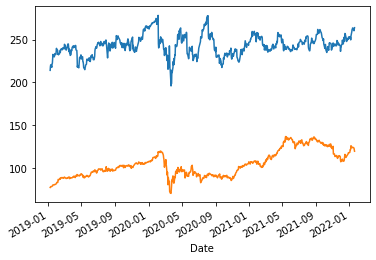

In [188]:
P1[5:].plot()
P2[5:].plot()

In [189]:
window = 30    #SELECT NUMBER OF DAYS FOR LOOKBACK
zs = 2.0


df_prices['ratio'] = df_prices['P1'] / df_prices['P2']
df_prices['mean'] = df_prices['ratio'].rolling(window=window).mean()
df_prices['stdev'] = df_prices['ratio'].rolling(window=window).std()

df_prices['z_up'] = df_prices['mean'] + (df_prices['stdev'] * zs)
df_prices['z_dwn'] = df_prices['mean'] - (df_prices['stdev'] * zs)

df_prices.fillna(0, inplace=True)



df_prices

,P1,P2,ratio,mean,stdev,z_up,z_dwn
Date,,,,,,,
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-02,211.583130,76.304626,2.772874,0.000000,0.000000,0.000000,0.000000
2019-01-03,203.045944,75.052200,2.705396,0.000000,0.000000,0.000000,0.000000
2019-01-04,208.612442,77.267296,2.699880,0.000000,0.000000,0.000000,0.000000
2019-01-07,210.198746,77.145790,2.724695,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2022-01-13,263.690002,124.160004,2.123792,2.179081,0.076165,2.331410,2.026752
2022-01-14,262.619995,124.080002,2.116538,2.176363,0.076914,2.330192,2.022534
2022-01-18,260.420013,123.220001,2.113456,2.171954,0.076591,2.325136,2.018771


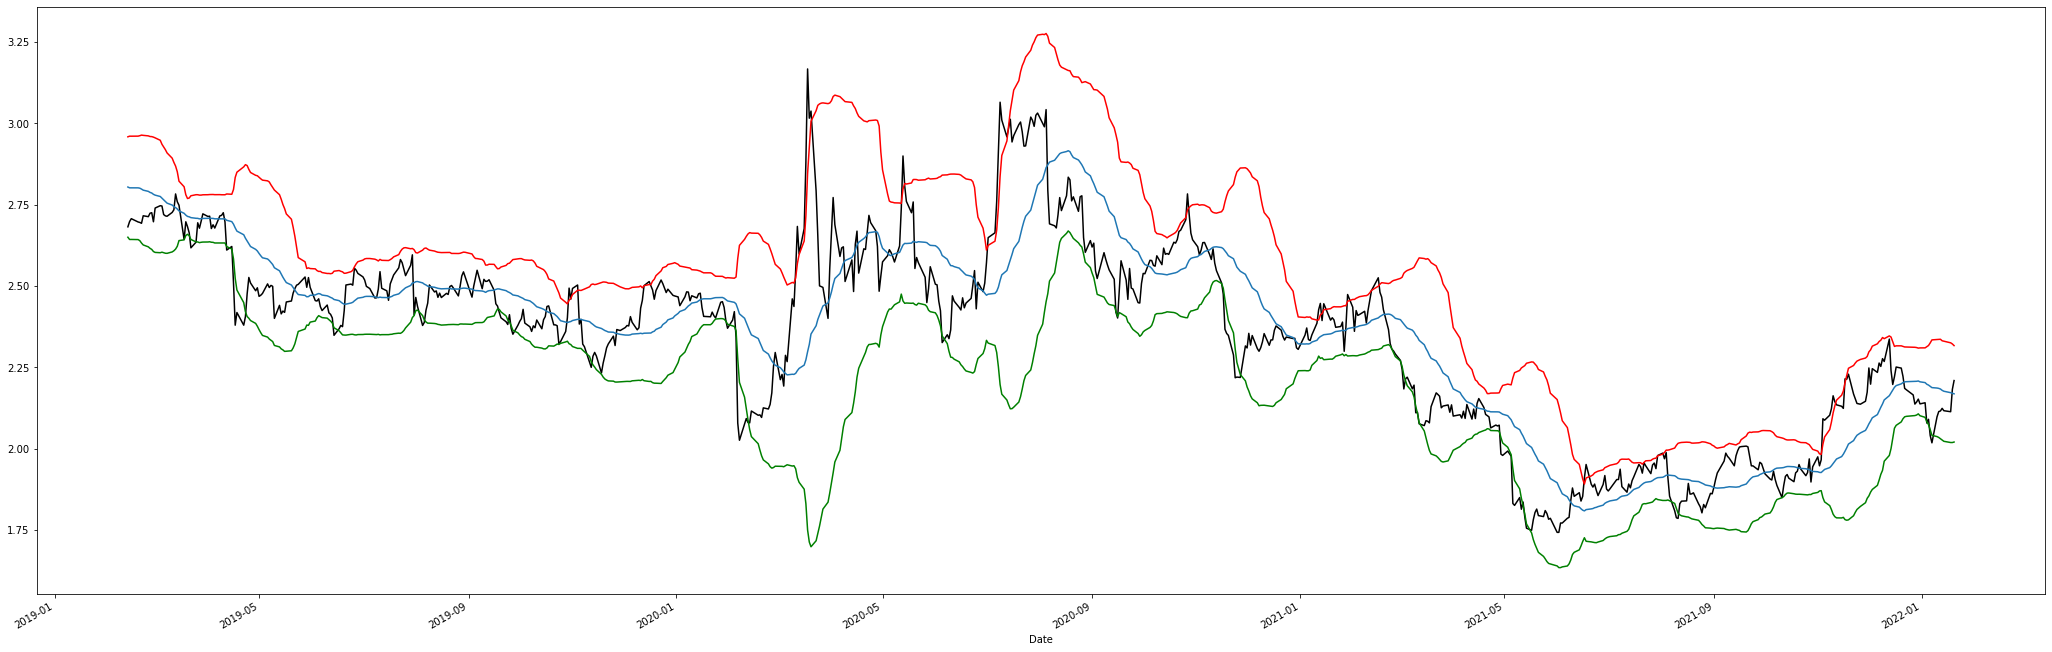

In [190]:
plt.figure(figsize=(36, 12))


df_prices['ratio'][window:].plot(color='k')
df_prices['mean'][window:].plot()
df_prices['z_up'][window:].plot(color='r')
df_prices['z_dwn'][window:].plot(color='g')

#Build BackTest

In [210]:
df_bt = df_prices.copy()




In [213]:
df_bt['oor_high'] = (df_bt['ratio'] > df_bt['z_up']).astype(int) * -1
df_bt['oor_low'] = (df_bt['ratio'] < df_bt['z_dwn']).astype(int)

In [214]:
df_bt

,P1,P2,ratio,mean,stdev,z_up,z_dwn,oor_high,oor_low
Date,,,,,,,,,
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2019-01-02,211.583130,76.304626,2.772874,0.000000,0.000000,0.000000,0.000000,-1,0
2019-01-03,203.045944,75.052200,2.705396,0.000000,0.000000,0.000000,0.000000,-1,0
2019-01-04,208.612442,77.267296,2.699880,0.000000,0.000000,0.000000,0.000000,-1,0
2019-01-07,210.198746,77.145790,2.724695,0.000000,0.000000,0.000000,0.000000,-1,0
...,...,...,...,...,...,...,...,...,...
2022-01-13,263.690002,124.160004,2.123792,2.179081,0.076165,2.331410,2.026752,0,0
2022-01-14,262.619995,124.080002,2.116538,2.176363,0.076914,2.330192,2.022534,0,0
2022-01-18,260.420013,123.220001,2.113456,2.171954,0.076591,2.325136,2.018771,0,0
